In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import os
import sys
import importlib
from glob import glob
from cytoolz import concat
import time
from scipy.signal import find_peaks
import gc
gc.collect()

from tabulate import tabulate

sys.path.append('/sdf/home/j/johntw/dev/')
import johntw_utils as jtw

sys.path.append('/sdf/home/j/johntw/FERMI/')
import Constants as c
import RunInfo as RI
import ECalibSupportFunctions as SF
for i in [c, RI, SF]:
    importlib.reload(i)

In [3]:
path = (SF.get_run_path(RI.base_path, RI.beamtime, mode='Beamtime')).format
run_info = RI.load_run_info()

runs = np.arange(272, 274)
runs = np.array([i for i in runs if i not in RI.exclude])

info = run_info[runs[0]]
sample = info['sample']
harmonics = info['harmonics']

Total number of files in the folder Run_272 to Run_273 are 100


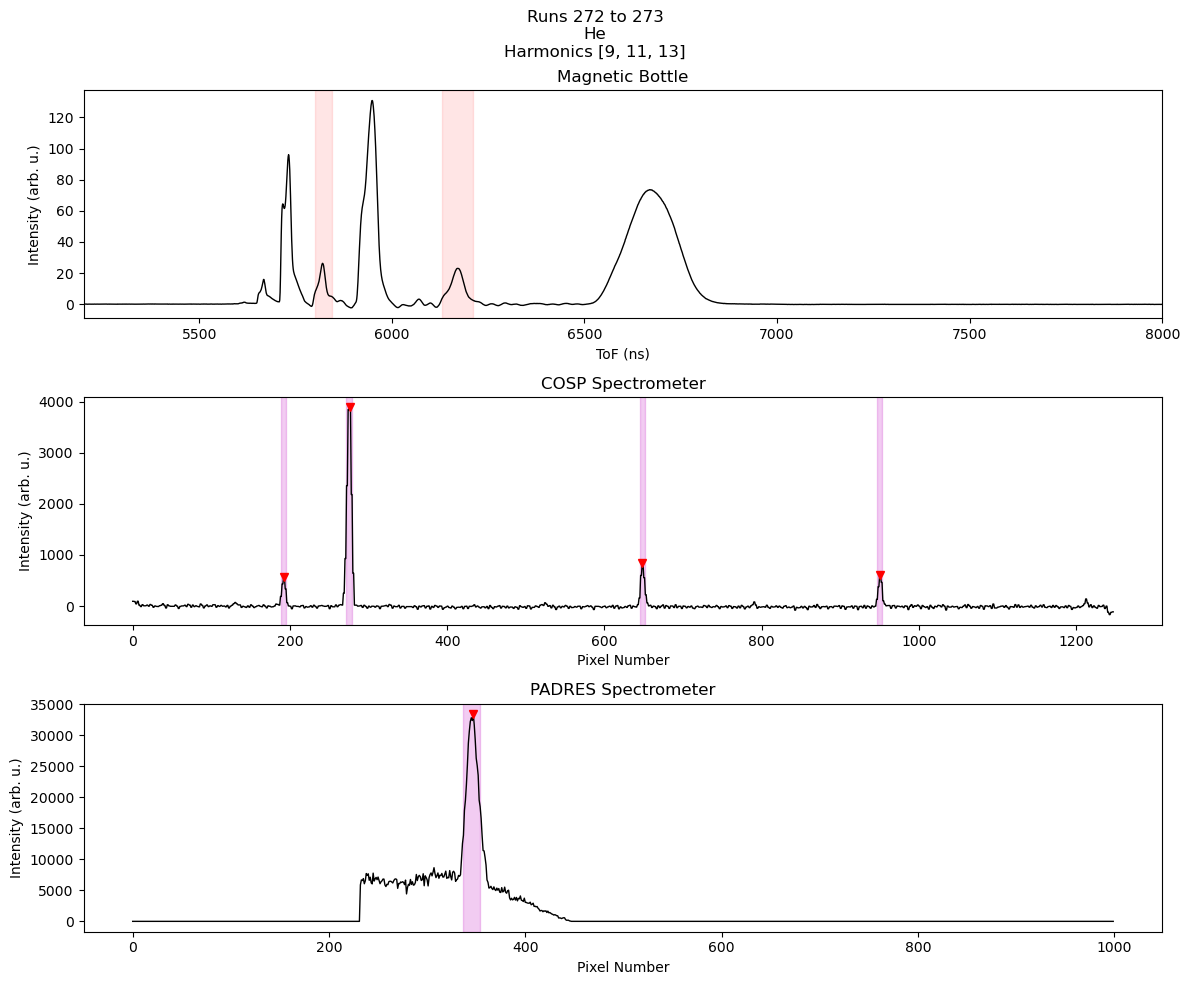

In [4]:
globbed = sorted(concat(glob(path(r)) for r in runs))
print(f'Total number of files in the folder Run_{runs[0]} to Run_{runs[-1]} are {len(globbed)}')
if len(globbed) >= 50:
    n = 25
else:
    n = len(globbed)

fr, to = 5100, 5300

TOF_All, Back_All, spectra_All, padres = [], [], [], []

for i in range(0, n):
    with h5py.File(globbed[i], 'r') as f:
        bp = f['Background_Period'][()]
        bunches = f['bunches'][...]
        where = bunches % bp != 0
        where1 = bunches % bp == 0
        tofs = f['digitizer/channel3'][...]
        arrs = np.average(tofs[:, fr:to],1)[:, None] - tofs
        TOF_All.append(arrs[where])
        Back_All.append(arrs[where1])
        spectra_All.append(f['cosp/HorSpectrum'][...])
        padres.append(f['/photon_diagnostics/Spectrometer/hor_spectrum'][...])
    del bunches, where

TOF_All = np.vstack(TOF_All)
Back_All = np.vstack(Back_All)

avg_TOF = np.mean(TOF_All, axis=0) - np.mean(Back_All, axis=0)

spectra_All = np.vstack(spectra_All)
padres_all = np.vstack(padres)

spectra_avg = np.mean(spectra_All, axis=0) - np.mean(np.mean(spectra_All, axis=0)[40:120])
padres_avg = np.mean(padres_all, axis=0)

peaks_spec, props_spec = find_peaks(spectra_avg, distance = 50, height = 200, width = 0.3, rel_height = 0.5, prominence = 0.1)
left_spec = np.array(props_spec['left_ips'], dtype=int)
right_spec = np.array(props_spec['right_ips'], dtype=int)
bins_spec = [[left_spec[i], right_spec[i]] for i in range(len(left_spec))]

peaks_pad, props_pad = find_peaks(padres_avg, distance = 500, height = 15000, width = 1, rel_height = 0.5, prominence = 0.5)
left_pad = np.array(props_pad['left_ips'], dtype=int)
right_pad = np.array(props_pad['right_ips'], dtype=int)
bins_pad = [[left_pad[i], right_pad[i]] for i in range(len(left_pad))]

plt.figure(figsize=(12,10))

plt.subplot(3,1,1)
plt.plot(avg_TOF, c='k', linewidth=1)
if sample == 'CO2':
    for i, col in zip(['X', 'A', 'B', 'C'], ['r', 'm', 'g', 'b']):
        if info['bins'][i] is not None:
            for k, j in enumerate(info['bins'][i]):
                if k == 0:
                    plt.axvspan(*j, color=col, alpha=0.1, label=i)
                else:
                    plt.axvspan(*j, color=col, alpha=0.1)

    plt.legend(loc='right', bbox_to_anchor=(1.1,0.5))
else:
    if info['bins']['Other'] is not None:
        for k, j in enumerate(info['bins']['Other']):
                plt.axvspan(*j, color='r', alpha=0.1)

plt.xlim([5200,8000])
plt.xlabel('ToF (ns)')
plt.ylabel('Intensity (arb. u.)')
plt.title('Magnetic Bottle')

plt.subplot(3,1,2)
plt.plot(spectra_avg, lw=1, c='k')
for b in bins_spec:
    plt.axvspan(*b, 0, 1000, color='m', alpha=0.2)
plt.plot(peaks_spec, spectra_avg[peaks_spec], 'rv')
plt.title('COSP Spectrometer')
plt.xlabel('Pixel Number')
plt.ylabel('Intensity (arb. u.)')

plt.subplot(3,1,3)
plt.plot(padres_avg, lw=1, c='k')
for b in bins_pad:
    plt.axvspan(*b, 0, 1000, color='m', alpha=0.2)
plt.plot(peaks_pad, padres_avg[peaks_pad], 'rv')
plt.title('PADRES Spectrometer')
plt.xlabel('Pixel Number')
plt.ylabel('Intensity (arb. u.)')

plt.suptitle(f'Runs {runs[0]} to {runs[-1]}\n{sample}\nHarmonics {harmonics}')
plt.tight_layout()
plt.show()

In [5]:
def process(filename):
    run_no = int(filename.split('_')[-2])

    with h5py.File(filename, 'r') as fh:
        bunches = fh['bunches'][...]
        
        try:
            hor_spectra = fh['/photon_diagnostics/Spectrometer/hor_spectrum'][..., 0:1000].astype('float64')
            ver_spectra = fh['/photon_diagnostics/Spectrometer/vert_spectrum'][..., 80:850].astype('float64')
        except:
            hor_spectra = np.zeros((100, 1000))
            ver_spectra = np.zeros((100, 1000))

        hors = np.fromiter((np.sum(hor_spectra,1)), 'float')
        vers = np.fromiter((np.sum(ver_spectra,1)), 'float')

        try:
            spectra = fh['/cosp/HorSpectrum'][..., :].astype('float64')
        except:
            spectra = np.zeros((100, 1600))

        spectra = spectra - np.average(spectra[:, 40:120], 1)[:, None]

        hars1 = np.fromiter((np.sum(hor_spectra[:, left_pad[0]:right_pad[0]], 1)), 'float')
        hars2 = np.fromiter((np.sum(spectra[..., left_spec[0]:right_spec[0]], 1)), 'float')
        hars3 = np.fromiter((np.sum(spectra[..., left_spec[1]:right_spec[1]], 1)), 'float')

        try:
            intensities = fh['photon_diagnostics/FEL01/I0_monitor/iom_uh_a_pc'][...].astype('float64')
            intensities1 = fh['photon_diagnostics/FEL01/I0_monitor/iom_uh_a'][...].astype('float64')
        except:
            intensities = np.zeros((100,1))
            intensities1 = np.zeros((100,1))

        try:
            phase1 = round(float(fh['photon_source/FEL01/PhaseShifter3/DeltaPhase'][()]), 3)
            phase2 = round(float(fh['photon_source/FEL01/PhaseShifter4/DeltaPhase'][()]), 3)
            phase3 = round(float(fh['photon_source/FEL01/PhaseShifter5/DeltaPhase'][()]), 3)
            phase4 = round(float(fh['photon_source/FEL01/PhaseShifter6/DeltaPhase'][()]), 3)
            phase5 = round(float(fh['photon_source/FEL01/PhaseShifter7/DeltaPhase'][()]), 3)
            lambda_s = round(float(fh['photon_source/SeedLaser/Wavelength'][()]), 3)
            harm_ref = fh['photon_source/FEL01/harmonic_number'][()]
        except:
            phase1, phase2, phase3, phase4, phase5 = 0, 0, 0, 0, 0
            lambda_s = 0
            harm_ref = 0

        try:
            tofs = fh['digitizer/channel3'][:, :].astype('int64')
        except:
            tofs = np.zeros((100, 60000))

        try:
            IR_energies = fh['user_laser/energy_meter/Energy2'][...].astype('float64')
        except:
            IR_energies = np.zeros(100)

        arrs = np.average(tofs[:, 5056:5300], 1)[:, None] - tofs
        # fmt = 'peak{}'.format

        return {
            'bunch': bunches,
            'hor': hors,
            'ver': vers,
            'H1': hars1,
            'H2': hars2,
            'H3': hars3,
            'Run': run_no,
            'intensity_pc': intensities,
            'intensity_uj': intensities1,
            'phase1': phase1,
            'phase2': phase2,
            'phase3': phase3,
            'phase4': phase4,
            'phase5': phase5,
            'lambda_s': lambda_s,
            'harm_ref': harm_ref,
            'IR_energy': IR_energies,
            'tofs': tofs,
            'arrs': arrs
        }

        # for bunch, hor, ver, har1, har2, har3, inten, inten1, arr, IR_energy in zip(bunches, hors, vers, hars1, hars2, hars3, intensities, intensities1, arrs, IR_energies):
        #     yield {
        #         'bunch': bunch,
        #         'hor': hor,
        #         'ver': ver,
        #         'H1': har1,
        #         'H2': har2,
        #         'H3': har3,
        #         'Run': run_no,
        #         'intensity_pc': inten,
        #         'intensity_uj': inten1,
        #         'phase1': phase1,
        #         'phase2': phase2,
        #         'phase3': phase3,
        #         'phase4': phase4,
        #         'phase5': phase5,
        #         'lambda_s': lambda_s,
        #         'harm_ref': harm_ref,
        #         'IR_energy': IR_energy,
        #     }

In [19]:
for key in data.keys():
    if hasattr(data[key], 'shape'):
        print(f'{key}: {data[key].shape}')
    else:
        print(f'{key}: {data[key]}')

bunch: (100,)
hor: (100,)
ver: (100,)
H1: (100,)
H2: (100,)
H3: (100,)
Run: 273
intensity_pc: (100,)
intensity_uj: (100,)
phase1: 1.74
phase2: 2.425
phase3: 1.878
phase4: 1.759
phase5: 2.104
lambda_s: 264.364
harm_ref: ()
IR_energy: (100,)
tofs: (100, 60000)
arrs: (100, 60000)


In [22]:
datas = {i: {} for i in runs}
runs_track = 0

tic = time.time()

for glob in globbed:
    data = process(glob)
    run_num = data['Run']

    if datas[run_num] == {}:
        if runs_track > 0:
            print(f'[{time.time() - tic:.3f}] Combining run {run_num - 1}')
            for key in data.keys():
                if isinstance(datas[run_num - 1][key], dict):
                    temp = np.array([datas[run_num-1][key][key_iter] for key_iter in datas[run_num-1][key].keys()])
                    if temp[0].ndim == 1:
                        datas[run_num - 1][key] = np.concatenate(temp)
                    else:
                        datas[run_num - 1][key] = np.vstack(temp)
                else:
                    continue
            print(f'[{time.time() - tic:.3f}] Collecting Garbage\n')
            gc.collect()
        
        print(f'[{time.time() - tic:.3f}] Starting run {run_num}')
        # print(f'\tFile {glob.split("/")[-1]}')
        
        for key in data.keys():
            if hasattr(data[key], 'shape'):
                datas[run_num][key] = {}
                datas[run_num][key][glob.split("/")[-1]] = data[key]
            else:
                datas[run_num][key] = data[key]
        # datas[run_num] = data
        runs_track += 1

    else:
        # print(f'\tFile {glob.split("/")[-1]}')
        for key in data.keys():
            if hasattr(data[key], 'shape'):
                datas[run_num][key][glob.split("/")[-1]] = data[key]
            else:
                continue
                
print(f'[{time.time() - tic:.3f}] Combining run {run_num}')
for key in data.keys():
    if isinstance(datas[run_num][key], dict):
        temp = np.array([datas[run_num][key][key_iter] for key_iter in datas[run_num][key].keys()])
        if temp[0].ndim == 1:
            datas[run_num][key] = np.concatenate(temp)
        else:
            datas[run_num][key] = np.vstack(temp)
    else:
        continue
print(f'[{time.time() - tic:.3f}] Collecting Garbage\n')
gc.collect()

[0.106] Starting run 272
[5.043] Combining run 272
[8.828] Collecting Garbage

[8.957] Starting run 273
[13.791] Combining run 273
[17.568] Collecting Garbage



0

In [24]:
print(datas[272]['H1'].shape)
print(datas[272]['tofs'].shape)

(5000,)
(5000, 60000)


In [8]:
# plt.plot(data['tofs'][0], label='tofs')
# plt.plot(data['arrs'][0], label='tof corrected')
# plt.xlim([5200, 8000])
# plt.xlabel('ToF (ns)')
# plt.title('ToFs')
# plt.legend()
# plt.show()

In [28]:
tofROI = (5500,7500)
run_num = 272

tof_axis = np.arange(*tofROI)
DtDs = np.zeros((tof_axis.shape[0], tof_axis.shape[0]))
Ds = np.zeros(tof_axis.shape[0])
ItIs = np.zeros((3,3))
DtIs = np.zeros((tof_axis.shape[0], 3))
Is = np.zeros(3)
n = 0

for i in range(datas[272]['tofs'].shape[0]):
    if i%100 == 0:
        print(f'Starting {i+1} of {datas[272]["tofs"].shape[0]}')
    DtDs += datas[272]['tofs'][i][slice(*tofROI),None]*datas[272]['tofs'][i][None,slice(*tofROI)]
    DtIs += datas[272]['tofs'][i][slice(*tofROI),None]*np.array([datas[272]['H1'][i],datas[272]['H2'][i],datas[272]['H3'][i]])[None,:]
    ItIs += np.array([datas[272]['H1'][i],datas[272]['H2'][i],datas[272]['H3'][i]])[:,None]*np.array([datas[272]['H1'][i],datas[272]['H2'][i],datas[272]['H3'][i]])[None,:]
    Ds += datas[272]['tofs'][i][slice(*tofROI)]
    Is += np.array([datas[272]['H1'][i],datas[272]['H2'][i],datas[272]['H3'][i]])
    n+=1

print(f'Calculating Covariance')
DtD = DtDs/n
DtI = DtIs/n
ItI = ItIs/n
D = Ds/n
I = Is/n
cDD = jtw.op2cov(DtD, D, D)
cDI = jtw.op2cov(DtI, D, I)
cII = jtw.op2cov(ItI, I, I)
pDD = cDD - cDI @ (np.linalg.inv(cII) @ cDI.T)
pDD_diag = np.array([pDD[i,i] for i in range(pDD.shape[0])])
pDD_diag_op = pDD_diag[:,None] * pDD_diag[None,:]
prDD = pDD/np.sqrt(pDD_diag_op)
print(f'Finished!')

Starting 1 of 5000
Starting 101 of 5000
Starting 201 of 5000
Starting 301 of 5000
Starting 401 of 5000
Starting 501 of 5000
Starting 601 of 5000


KeyboardInterrupt: 

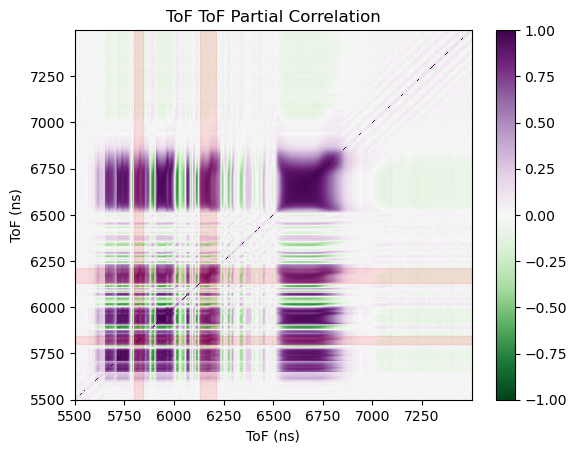

In [27]:
%matplotlib inline
plt.close('all')
plt.pcolormesh(tof_axis, tof_axis, prDD, cmap='PRGn_r')
plt.xlabel('ToF (ns)')
plt.ylabel('ToF (ns)')
plt.title('ToF ToF Partial Correlation')
plt.colorbar()
plt.clim([-1,1])

if sample == 'CO2':
    for i, col in zip(['X', 'A', 'B', 'C'], ['r', 'm', 'g', 'b']):
        if info['bins'][i] is not None:
            for k, j in enumerate(info['bins'][i]):
                if k == 0:
                    plt.axvspan(*j, color=col, alpha=0.1, label=i)
                    plt.axhspan(*j, color=col, alpha=0.1)
                else:
                    plt.axvspan(*j, color=col, alpha=0.1)
                    plt.axhspan(*j, color=col, alpha=0.1)

    plt.legend(loc='right', bbox_to_anchor=(1.1,0.5))
else:
    if info['bins']['Other'] is not None:
        for k, j in enumerate(info['bins']['Other']):
                plt.axvspan(*j, color='r', alpha=0.1)
                plt.axhspan(*j, color='r', alpha=0.1)

plt.show()

In [34]:
print(data.keys())

dict_keys(['bunch', 'hor', 'ver', 'H1', 'H2', 'H3', 'Run', 'intensity_pc', 'intensity_uj', 'phase1', 'phase2', 'phase3', 'phase4', 'phase5', 'lambda_s', 'harm_ref', 'IR_energy', 'tofs', 'arrs'])


In [36]:
with h5py.File('/sdf/scratch/lcls/ds/tmo/tmol1043723/scratch/jtw/op_run272.h5', 'r') as fh:
    print(fh.keys())
    phases = fh['phases'][...]

<KeysViewHDF5 ['D', 'DtD', 'DtI', 'I', 'ItI', 'n', 'phases', 'tof_axis']>


In [37]:
print(phases)

[1.74  2.55  1.878 1.759 2.104]
